In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
from random import randint
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_DNA_REPi/Expression_CNA/Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
em_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_DNA_REPi/Expression_Mutation/Predictions/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_DNA_REPi/Expression_Mutation_CNA/Predictions/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_DNA_REPi/Expression_CNA/Predictions/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_DNA_REPi/Expression_CNA/Figures/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent
,TOTAL:,1001,996,968,957,990,,,,,,


In [6]:
# change directory to read GDSC expression dataset (DNA_REPi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (DNA_REPi)

GDSCE = pd.read_csv("GDSC_exprs.z.DNA_REPi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
684055,1.3565140948247052,-0.277542411913307,0.0887087882196536,-0.2754829982302413,-0.5153856346587746,-0.6248712076433911,0.1243408990866293,-1.2699667684674136,2.0788360886382717,2.5197991997459197,...,-0.5571028630154293,-1.724090733574364,-0.3749080365068901,-0.0016055431935905,-0.3788535663547365,-1.3502092798315848,0.6949790577550328,0.4333032198982747,-0.1280986270308099,-1.629249958712223
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [8]:
# change directory to read GDSC CNA dataset (DNA_REPi)

os.chdir(dataset_dir + "/CNA/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA


In [9]:
# read GDSC CNA dataset (DNA_REPi)

GDSCC = pd.read_csv("GDSC_CNA.DNA_REPi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCC.drop_duplicates(keep='last')
GDSCC = pd.DataFrame.transpose(GDSCC)
GDSCC = GDSCC.loc[:, ~GDSCC.columns.duplicated()]

GDSCC.head()

gene_id,1,2,9,10,12,13,14,15,16,18,...,107985535,107985759,107986588,107986809,107986898,107987337,107987341,109731405,112441434,121676927
683665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,1.807355,0.000000,0.000000,0.000000
684055,0.000000,0.584963,0.584963,0.584963,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.584963,0.000000,0.584963,0.584963,-4.32,-4.320000,0.000000,0.000000,0.584963
684057,-0.415037,0.000000,0.584963,0.584963,-1.000000,0.000000,0.0,0.0,-0.415037,-0.415037,...,-0.415037,0.000000,0.000000,0.000000,0.807355,-1.00,-1.000000,-0.415037,-0.415037,0.807355
684059,0.000000,0.000000,0.000000,0.000000,0.000000,0.415037,0.0,0.0,0.000000,0.415037,...,0.000000,0.000000,0.415037,0.000000,0.415037,-4.32,-4.320000,0.000000,0.000000,0.736966
684062,-0.415037,0.000000,0.321928,0.321928,-0.415037,-0.415037,0.0,0.0,-0.415037,0.000000,...,-0.415037,0.000000,0.000000,0.000000,0.321928,-4.32,-4.320000,-0.415037,-1.000000,0.321928


In [10]:
# change directory to read GDSC response dataset (DNA_REPi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (DNA_REPi)

GDSCR = pd.read_csv("GDSC_response.DNA_REPi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,5.12075503641523,Pyrimethamine,1,1,1
683665,0,-3.03711635474651,Doxorubicin,1,1,1
683665,0,-0.712119156515401,Etoposide,1,1,1
683665,0,-4.40897202584936,Gemcitabine,1,1,1
683665,0,-1.59752443691324,Mitomycin C,1,1,1


In [12]:
# print count of cell lines for each drug (DNA_REPi)

GDSCR["drug"].value_counts()

drug
Etoposide         775
SN-38             771
Mitomycin C       767
Doxorubicin       766
5-Fluorouracil    764
Gemcitabine       761
Bleomycin         759
Temozolomide      752
Cisplatin         738
Methotrexate      738
Camptothecin      737
Cytarabine        735
Pyrimethamine     372
Name: count, dtype: int64

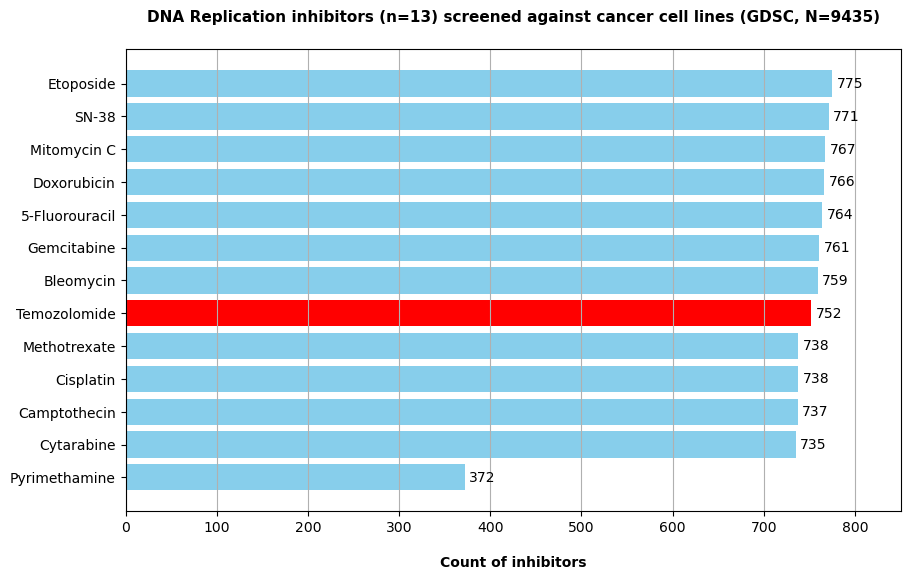

In [13]:
# plot DNA replication inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Temozolomide":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'DNA Replication inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'DNA Replication Inhibitors with Their Counts (GDSC, Temozolomide).png', format='png', bbox_inches='tight')

plt.show()

In [14]:
# change directory to read TCGA expression dataset homogenized with GDSC expression dataset (Temozolomide)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read TCGA expression dataset homogenized with GDSC expression dataset (Temozolomide)

TCGAEtemozolomide = pd.read_csv("TCGA_exprs.Temozolomide.eb_with.GDSC_exprs.Temozolomide.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEtemozolomide = pd.DataFrame.transpose(TCGAEtemozolomide)
TCGAEtemozolomide.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-DB-A4XB-01A,3.01411500679127,3.21429233402942,6.4528333134497,2.95628179386887,2.11182452311578,2.96154806728763,8.49988388272576,2.62293993624751,8.9387140767194,4.15154137558802,...,9.17318432966048,2.64970810303467,2.74560040876787,3.32036177484863,3.45134028609217,2.84865221646127,3.28055555566557,2.72651224971197,5.5924078445875,4.99760858931826
TCGA-DB-A4XD-01A,4.64454942106989,4.2132521109463,4.98533650210385,2.49132421622367,2.26592937938765,2.96154806728763,8.11985458578506,2.36514294812994,8.56015015827888,4.34906181922056,...,9.00189428232398,2.62642389297931,2.74560040876787,3.09176896498447,3.58343753923839,2.44226819244948,2.53952138693823,2.72651224971197,4.44402883666404,4.2826105962019
TCGA-DB-A4XF-01A,3.81691719009577,4.61811398228358,5.61623849668032,4.35255263922777,5.35342357746377,2.96154806728763,7.70766074541521,2.51636328208313,8.25973564321625,4.07335851817075,...,8.87919475426985,2.80493720046034,2.74560040876787,3.00804657882649,3.97492729783926,2.72074746077948,2.68867433708246,2.72651224971197,4.42517105663064,4.56343673951182


In [16]:
# change directory to read TCGA CNA dataset (Temozolomide)

os.chdir(dataset_dir + "CNA")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA'

In [17]:
# read TCGA CNA dataset (Temozolomide)

TCGACtemozolomide = pd.read_csv("TCGA_CNA.Temozolomide.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGACtemozolomide.drop_duplicates(keep='last')
TCGACtemozolomide = pd.DataFrame.transpose(TCGACtemozolomide)
TCGACtemozolomide = TCGACtemozolomide.loc[:, ~TCGACtemozolomide.columns.duplicated()]

TCGACtemozolomide.head(3)

,1,24,34,69,81,116,140,143,160,178,...,100505971,100505987,100506011,100506032,100506528,100507552,100533719,100533720,100652757,100652887
TCGA-DB-A4XB-01A,-0.8659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.8659,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-DB-A4XD-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-DB-A4XF-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# variance threshold for GDSC expression dataset (DNA_REPi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [19]:
# fill NA values and binarize GDSC CNA dataset (DNA_REPi)

GDSCC = GDSCC.fillna(0)
GDSCC[GDSCC != 0.0] = 1

In [20]:
# select shared genes between GDSC and TCGA expression and CNA datasets 

ls = GDSCE.columns.intersection(GDSCC.columns)
ls = ls.intersection(TCGAEtemozolomide.columns)
ls = ls.intersection(TCGACtemozolomide.columns)

ls = pd.unique(ls)

print(f"GDSC and TCGA # of common genes: {ls.shape[0]}")

GDSC and TCGA # of common genes: 16389


In [21]:
# select shared samples between GDSC expression and response datasets (DNA_REPi)

ls2 = GDSCE.index.intersection(GDSCC.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 801


In [22]:
# subset shared genes and samples in GDSC expression, CNA, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCC = GDSCC.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCC.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

# There exists same sample names for different drugs, so row shape is different in GDSC response data

GDSC # of common samples and genes (Expression): (801, 16389)
GDSC # of common samples and genes (CNA): (801, 16389)
GDSC # of samples (Response): 9435


In [23]:
# select shared samples between TCGA expression and CNA datasets (Temozolomide) 

ls3 = TCGAEtemozolomide.index.intersection(TCGACtemozolomide.index)

print(f"TCGA # of common samples (Temozolomide): {ls3.shape[0]}")

TCGA # of common samples (Temozolomide): 90


In [24]:
# select shared genes and samples between TCGA expression and CNA datasets (Temozolomide)

TCGAEtemozolomide = TCGAEtemozolomide.loc[ls3, ls]
TCGACtemozolomide = TCGACtemozolomide.loc[ls3, ls]

print(f"TCGA # of common samples and genes for Expression (Temozolomide): {TCGAEtemozolomide.shape}")
print(f"TCGA # of common samples and genes for CNA (Temozolomide): {TCGACtemozolomide.shape}\n")

TCGA # of common samples and genes for Expression (Temozolomide): (90, 16389)
TCGA # of common samples and genes for CNA (Temozolomide): (90, 16389)



In [25]:
# change directory to read DEGs (DNA_REPi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi


In [26]:
# read DEGs (DNA_REPi)

DEGs_filtered_data = pd.read_excel("DNA_REPi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among DNA replication inhibitors\n")

DEGs_filtered_data.head()

There are 858 DEGs (p-adjusted < 0.05 and |logFC| > 1) among DNA replication inhibitors



,Gene Symbol,Frequency
0,SLFN11,9
1,NCKAP1L,8
2,SDC4,7
3,KRT18,7
4,S100A14,7


In [27]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id.shape[0]

1 input query terms found dup hits:	[('CLECL1P', 2)]


858

In [28]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
cna = GDSCC
responses = GDSCR

In [29]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,5.12075503641523,Pyrimethamine,1,1,1
683665,0,-3.03711635474651,Doxorubicin,1,1,1
683665,0,-0.712119156515401,Etoposide,1,1,1


In [30]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'5-Fluorouracil',
 'Bleomycin',
 'Camptothecin',
 'Cisplatin',
 'Cytarabine',
 'Doxorubicin',
 'Etoposide',
 'Gemcitabine',
 'Methotrexate',
 'Mitomycin C',
 'Pyrimethamine',
 'SN-38',
 'Temozolomide'}

In [31]:
# convert Entrez gene IDs to integer

responses.index = responses.index.astype(int)
responses.index

Index([ 683665,  683665,  683665,  683665,  683665,  683665,  683665,  683665,
        683665,  683665,
       ...
       1659818, 1659818, 1659818, 1659818, 1659819, 1659819, 1659819, 1659819,
       1659819,  687800],
      dtype='int64', length=9435)

In [32]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
dat.head()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties,response,logIC50,drug,exprs,CNA,mutations
COSMIC identifier,,,,,,,,,,,,,,,,,,
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,3.25484543425934,Pyrimethamine,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,-3.08563930086988,Doxorubicin,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,1,-2.64209579180854,Etoposide,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,-2.92273746018911,Gemcitabine,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,-1.0950578547037,Mitomycin C,1,1,1


In [33]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    639
lung_small_cell_carcinoma    569
glioma                       558
breast                       524
melanoma                     522
Name: count, dtype: int64

In [34]:
# get count of total LGG tissues

tissues = dat["GDSC\nTissue\ndescriptor 2"].value_counts()
count_selected_tissues = tissues["glioma"].astype(int) 
count_selected_tissues

558

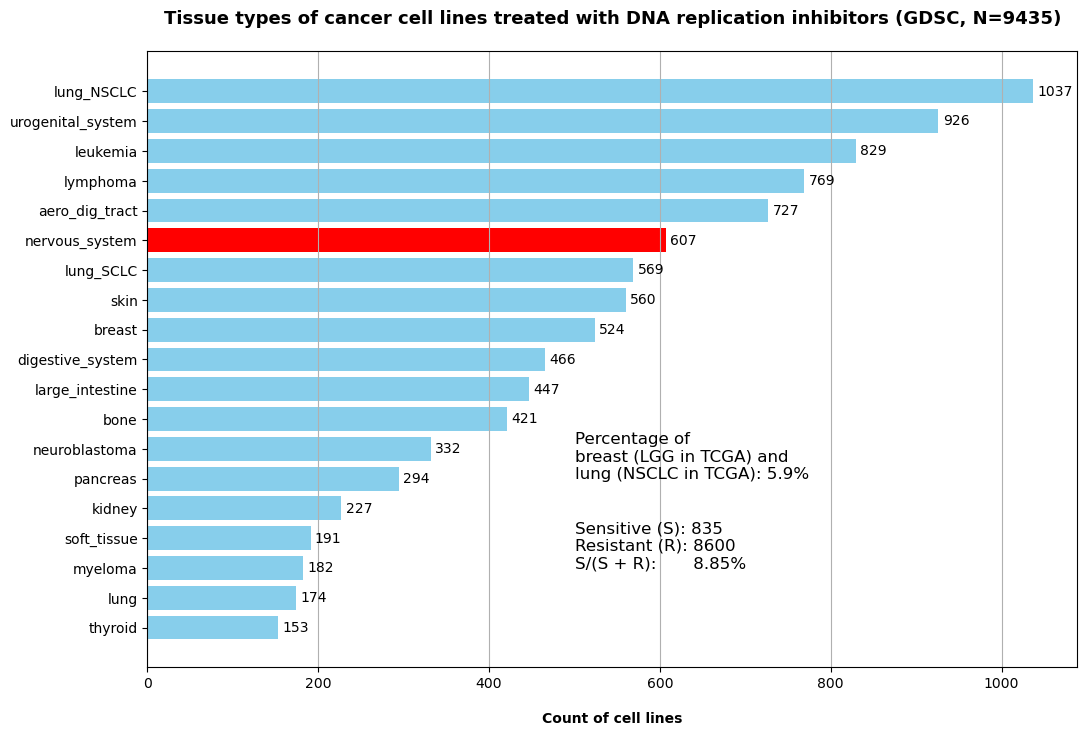

In [35]:
# plot tissue types of cancer cell lines treated with DNA replication inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with DNA replication inhibitors (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "nervous_system":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(500, 13, 
         f'Percentage of \nbreast (LGG in TCGA) and \nlung (NSCLC in TCGA): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(500, 16, 
         f'Sensitive (S): {dat[["response"]].value_counts()[1]} \nResistant (R): {dat[["response"]].value_counts()[0]} \nS/(S + R):       {round(dat[["response"]].value_counts()[1]/(sum(dat[["response"]].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')


plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with DNA replication inhibitors (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [36]:
# list count of cell lines as to tissues treated with Temozolomide

filter = (dat["drug"] == "Temozolomide")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
lung_NSCLC           87
urogenital_system    79
leukemia             66
lymphoma             59
aero_dig_tract       58
nervous_system       48
skin                 45
breast               41
lung_SCLC            40
digestive_system     38
large_intestine      37
bone                 34
neuroblastoma        23
pancreas             21
kidney               19
soft_tissue          16
myeloma              14
lung                 14
thyroid              13
Name: count, dtype: int64

In [37]:
# list count of cell lines as to tissues treated with Temozolomide

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Temozolomide")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    54
glioma                       45
melanoma                     42
breast                       41
lung_small_cell_carcinoma    40
Name: count, dtype: int64

In [38]:
# count of LGG and NSCLC cell lines treated with Temozolomide

count_selected_tissues = tissues_drug["glioma"].astype(int) 

count_selected_tissues

45

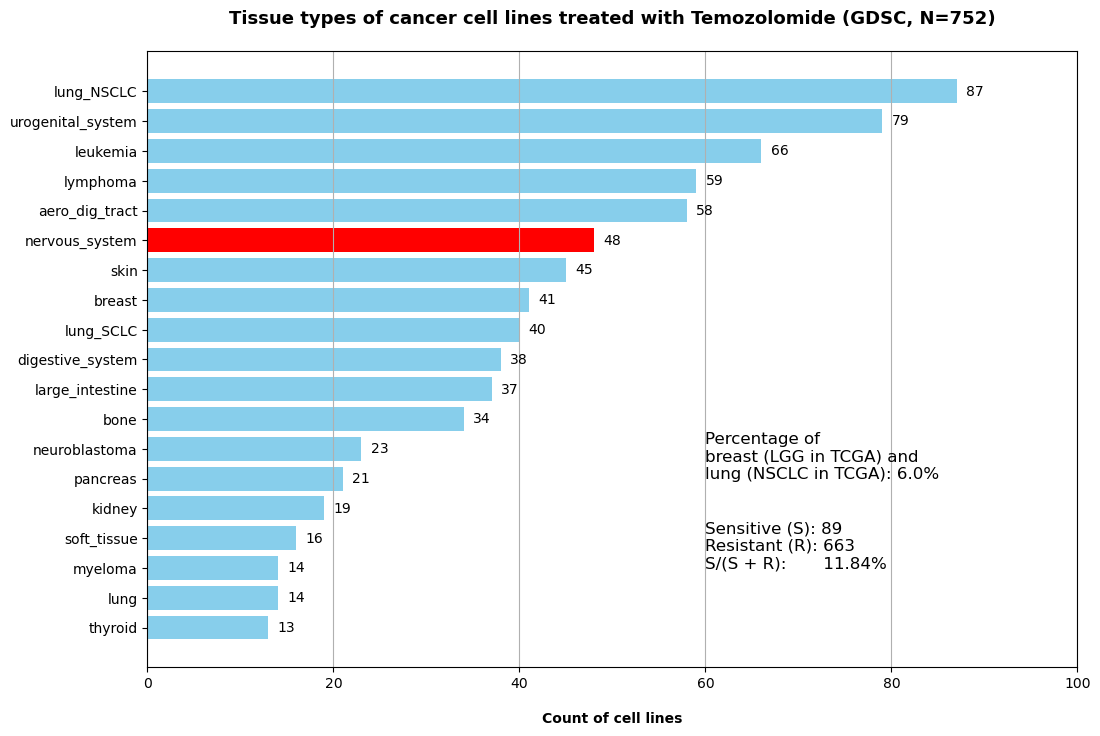

In [39]:
# plot tissue types of cancer cell lines treated with Temozolomide

gdsc_tissue_counts =  tissues_drugs.loc[filter, 'GDSC\nTissue descriptor 1'].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with Temozolomide (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.xlim(0, 100)
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 1, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "nervous_system":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(60, 13, 
         f'Percentage of \nbreast (LGG in TCGA) and \nlung (NSCLC in TCGA): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(60, 16, 
         f'Sensitive (S): {dat.loc[dat["drug"] == "Temozolomide", "response"].value_counts()[1]} \nResistant (R): {dat.loc[dat["drug"] == "Temozolomide", "response"].value_counts()[0]} \nS/(S + R):       {round(dat.loc[dat["drug"] == "Temozolomide", "response"].value_counts()[1]/(sum(dat.loc[dat["drug"] == "Temozolomide", "response"].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')

plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with Temozolomide (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [40]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683665',
       ...
       '1659818', '1659818', '1659818', '1659818', '1659819', '1659819',
       '1659819', '1659819', '1659819', '687800'],
      dtype='object', length=9435)

In [41]:
# filter GDSC expression and CNA datasets (DNA_REPi) as to drugs
# subset selected DEGs

expression_zscores = []
CNA = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    c = cna.loc[samples, :]
    expression_zscores.append(e_z)
    CNA.append(c)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCCv2 = pd.concat(CNA, axis=0)
GDSCRv2 = responses

ls4 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls5 = GDSCEv2.index.intersection(GDSCCv2.index)

GDSCEv2 = GDSCEv2.loc[ls5, ls4]
GDSCCv2 = GDSCCv2.loc[ls5, ls4]
GDSCRv2 = GDSCRv2.loc[ls5, :]

TCGAEtemozolomide = TCGAEtemozolomide.loc[:,ls4]
TCGACtemozolomide = TCGACtemozolomide.loc[:,ls4]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCCv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"TCGA # of common samples and genes for Temozolomide (Expression): {TCGAEtemozolomide.shape}")
print(f"TCGA # of common samples and genes for Temozolomide (CNA): {TCGACtemozolomide.shape}\n")

GDSC # of common samples and genes (Expression): (9435, 772)
GDSC # of common samples and genes (CNA): (9435, 772)
GDSC # of common samples (Response): 9435

TCGA # of common samples and genes for Temozolomide (Expression): (90, 772)
TCGA # of common samples and genes for Temozolomide (CNA): (90, 772)



In [42]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 1 0]


In [43]:
# change directory to read TCGA response dataset (Temozolomide)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [44]:
# read TCGA response dataset (Temozolomide)

TCGARtemozolomide = pd.read_csv("TCGA_response.Temozolomide.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARtemozolomide.dropna(inplace=True)
TCGARtemozolomide.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARtemozolomide["response"] = TCGARtemozolomide.loc[:, "response"].apply(lambda x: d[x])
Ytstemozolomide = TCGARtemozolomide["response"].values    

print(f"There are {Ytstemozolomide.shape[0]} samples with response data in the TCGA (Temozolomide)\n")
Ytstemozolomide

There are 90 samples with response data in the TCGA (Temozolomide)



array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0])

In [45]:
# TCGA cohort table with TCGA response dataset (Temozolomide)

dat_tcga = TCGARtemozolomide["cohort"]

dat_tcga.value_counts()

cohort
LGG    90
Name: count, dtype: int64

In [46]:
# filter LGG cohort samples (Temozolomide)

filter = (TCGARtemozolomide["cohort"] == "LGG")
tcga_lgg_samples = dat_tcga.loc[filter,].index
tcga_lgg_samples

Index(['TCGA-DB-A4XB-01A', 'TCGA-DB-A4XD-01A', 'TCGA-DB-A4XF-01A',
       'TCGA-DB-A4XG-01A', 'TCGA-DB-A64O-01A', 'TCGA-DB-A64P-01A',
       'TCGA-DB-A64V-01A', 'TCGA-DB-A64W-01A', 'TCGA-DB-A64X-01A',
       'TCGA-DB-A75K-01A', 'TCGA-DH-A66B-01A', 'TCGA-DH-A66D-01A',
       'TCGA-DH-A66G-01A', 'TCGA-DH-A7UR-01A', 'TCGA-DH-A7UT-01A',
       'TCGA-DH-A7UU-01A', 'TCGA-DH-A7UV-01A', 'TCGA-DU-8162-01A',
       'TCGA-DU-8163-01A', 'TCGA-DU-8165-01A', 'TCGA-DU-8166-01A',
       'TCGA-DU-8168-01A', 'TCGA-DU-A5TS-01A', 'TCGA-DU-A5TY-01A',
       'TCGA-DU-A6S6-01A', 'TCGA-DU-A6S7-01A', 'TCGA-DU-A76K-01A',
       'TCGA-DU-A76O-01A', 'TCGA-DU-A76R-01A', 'TCGA-DU-A7TA-01A',
       'TCGA-E1-A7YW-01A', 'TCGA-FG-6689-01A', 'TCGA-FG-7638-01B',
       'TCGA-FG-8189-01B', 'TCGA-FG-8191-01A', 'TCGA-FG-A4MW-01A',
       'TCGA-FG-A6J3-01A', 'TCGA-FG-A70Y-01A', 'TCGA-FG-A711-01A',
       'TCGA-FN-7833-01A', 'TCGA-HT-7884-01B', 'TCGA-HT-8114-01A',
       'TCGA-HT-8564-01A', 'TCGA-HT-A5RA-01A', 'TCGA-HT-A5RC-0

In [47]:
# filter responses of LGG cohort samples (Temozolomide)

Ytstemozolomide_lgg = TCGARtemozolomide.loc[tcga_lgg_samples,"response"].values
Ytstemozolomide_lgg

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0])

In [48]:
# count of sensitive and resistance LGG samples (Temozolomide)

TCGARtemozolomide.loc[tcga_lgg_samples,"response"].value_counts()

response
0    79
1    11
Name: count, dtype: int64

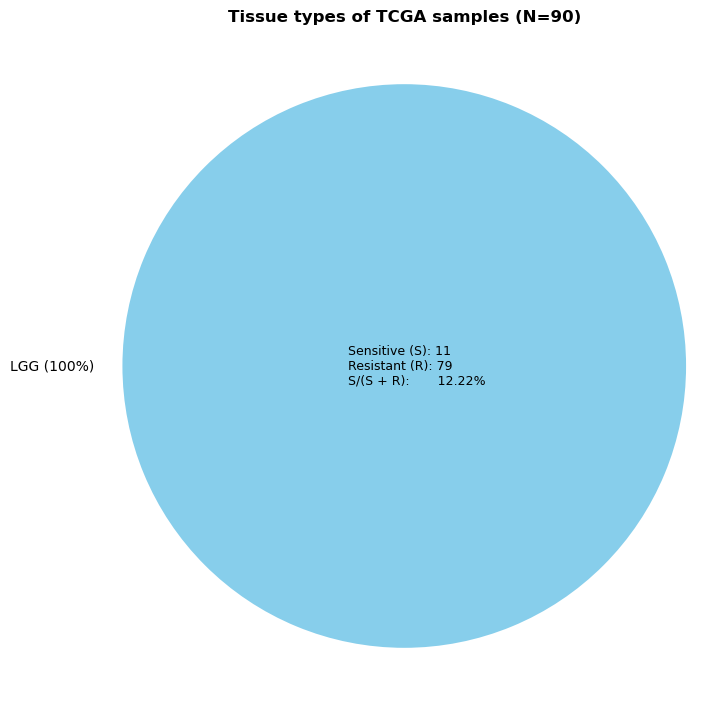

In [49]:
# plot tissue types of TCGA samples 

labels = list(dat_tcga.value_counts().index)
sizes = list(dat_tcga.value_counts())
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_percentages, startangle=0, colors=['skyblue'])
plt.title(f'Tissue types of TCGA samples (N={total})', fontweight = "bold")
plt.subplots_adjust(top=0.95) 
plt.axis('equal')  

plt.text(-0.2, 0, 
         f'Sensitive (S): {TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts().get(1,0)} \nResistant (R): {TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts().get(1,0)/(sum(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts())) * 100, 2)}%', 
         fontsize=9, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of TCGA samples (Temozolomide).png', format='png', bbox_inches='tight')

plt.show()

In [50]:
# define maximum iteration

max_iter = 50

In [51]:
# assign number of neurons and dropout rates found for layers from the saved models

hdm1 = 256
hdm2 = 1024
rate1 = 0.3
rate2 = 0.4
rate3 = 0.6

In [52]:
# load pre-trained models and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEtemozolomide = scalerGDSC.transform(TCGAEtemozolomide.values)    

X_testEtemozolomide = scalerGDSC.transform(TCGAEtemozolomide.values)    
X_testEtemozolomide_lgg = scalerGDSC.transform(TCGAEtemozolomide.loc[tcga_lgg_samples,].values)    

X_trainC = np.nan_to_num(GDSCCv2.values)
X_testCtemozolomide = np.nan_to_num(TCGACtemozolomide.values.astype(np.float32))
X_testCtemozolomide_lgg = np.nan_to_num(TCGACtemozolomide.loc[tcga_lgg_samples,].values)

TX_testEtemozolomide = torch.FloatTensor(X_testEtemozolomide)
TX_testCtemozolomide = torch.FloatTensor(X_testCtemozolomide.astype(np.float32))
ty_testEtemozolomideorouracil = torch.FloatTensor(Ytstemozolomide.astype(int))

TX_testEtemozolomide = torch.FloatTensor(X_testEtemozolomide)
TX_testEtemozolomide_lgg = torch.FloatTensor(X_testEtemozolomide_lgg)

TX_testCtemozolomide = torch.FloatTensor(X_testCtemozolomide.astype(np.float32))
TX_testCtemozolomide_lgg = torch.FloatTensor(X_testCtemozolomide_lgg.astype(np.float32))

n_sampE, IE_dim = X_trainE.shape
n_sampC, IC_dim = X_trainC.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2 

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()
        self.EnC = torch.nn.Sequential(
            nn.Linear(IC_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnC(x)
        return output       

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA.pt")
AutoencoderC = torch.load(models_dir + "CNA_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA.pt")

Clas = torch.load(models_dir + "Class_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA.pt")

AutoencoderE.eval()
AutoencoderC.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZCX = AutoencoderC(torch.FloatTensor(X_trainC))
ZTX = torch.cat((ZEX, ZCX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUC (TCGA_DNA_REPi): {round(AUCT,2)}")
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUCPR (TCGA_DNA_REPi): {round(AUCTaucpr,2)}\n")

ZETtemozolomide = AutoencoderE(TX_testEtemozolomide)
ZCTtemozolomide = AutoencoderC(TX_testCtemozolomide)
ZTTtemozolomide = torch.cat((ZETtemozolomide, ZCTtemozolomide), 1)
ZTTtemozolomide = F.normalize(ZTTtemozolomide, p=2, dim=0)
PredTtemozolomide = Clas(ZTTtemozolomide)
AUCTtemozolomide = roc_auc_score(Ytstemozolomide.astype(int), PredTtemozolomide.detach().numpy())
#print(f"TCGA - Test AUC (Temozolomide): {round(AUCTtemozolomide,2)}")
AUCTtemozolomide_aucpr = average_precision_score(Ytstemozolomide.astype(int), PredTtemozolomide.detach().numpy())
#print(f"TCGA - Test AUCPR (Temozolomide): {round(AUCTtemozolomide_aucpr,2)}\n")

ZETtemozolomide_lgg = AutoencoderE(TX_testEtemozolomide_lgg)
ZCTtemozolomide_lgg = AutoencoderC(TX_testCtemozolomide_lgg)
ZTTtemozolomide_lgg = torch.cat((ZETtemozolomide_lgg, ZCTtemozolomide_lgg), 1)
ZTTtemozolomide_lgg = F.normalize(ZTTtemozolomide_lgg, p=2, dim=0)
PredTtemozolomide_lgg = Clas(ZTTtemozolomide_lgg)
AUCTtemozolomide_lgg = roc_auc_score(Ytstemozolomide_lgg.astype(int), PredTtemozolomide_lgg.detach().numpy())
#print(f"TCGA - Test AUC (Temozolomide, LGG): {round(AUCTtemozolomide_lgg,2)}")
AUCTtemozolomide_lgg_aucpr = average_precision_score(Ytstemozolomide_lgg.astype(int), PredTtemozolomide_lgg.detach().numpy())
#print(f"TCGA - Test AUCPR (Temozolomide, LGG): {round(AUCTtemozolomide_lgg_aucpr,2)}")

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTtemozolomide_finetuned = dict()
AUCTtemozolomide_lgg_finetuned = dict()
AUCTtemozolomide_aucpr_finetuned = dict()
AUCTtemozolomide_lgg_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(models_dir + f"Finetuned_Models/Exprs_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_{iter}.pt")
   AutoencoderC_finetuned = torch.load(models_dir + f"Finetuned_Models/CNA_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(models_dir + f"Finetuned_Models/Class_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderC_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZCX = AutoencoderC_finetuned(torch.FloatTensor(X_trainC))
   ZTX = torch.cat((ZEX, ZCX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETtemozolomide = AutoencoderE_finetuned(TX_testEtemozolomide)
   ZCTtemozolomide = AutoencoderC_finetuned(TX_testCtemozolomide)
   ZTTtemozolomide = torch.cat((ZETtemozolomide, ZCTtemozolomide), 1)
   ZTTtemozolomide = F.normalize(ZTTtemozolomide, p=2, dim=0)
   PredTtemozolomide = Clas_finetuned(ZTTtemozolomide)
   AUCTtemozolomide_finetuned[iter] = roc_auc_score(Ytstemozolomide.astype(int), PredTtemozolomide.detach().numpy())
   AUCTtemozolomide_aucpr_finetuned[iter] = average_precision_score(Ytstemozolomide.astype(int), PredTtemozolomide.detach().numpy())

   ZETtemozolomide_lgg = AutoencoderE_finetuned(TX_testEtemozolomide_lgg)
   ZCTtemozolomide_lgg = AutoencoderC_finetuned(TX_testCtemozolomide_lgg)
   ZTTtemozolomide_lgg = torch.cat((ZETtemozolomide_lgg, ZCTtemozolomide_lgg), 1)
   ZTTtemozolomide_lgg = F.normalize(ZTTtemozolomide_lgg, p=2, dim=0)
   PredTtemozolomide_lgg = Clas_finetuned(ZTTtemozolomide_lgg)
   AUCTtemozolomide_lgg_finetuned[iter] = roc_auc_score(Ytstemozolomide_lgg.astype(int), PredTtemozolomide_lgg.detach().numpy())
   AUCTtemozolomide_lgg_aucpr_finetuned[iter] = average_precision_score(Ytstemozolomide_lgg.astype(int), PredTtemozolomide_lgg.detach().numpy())

max_key = max(AUCTtemozolomide_aucpr_finetuned, key=AUCTtemozolomide_aucpr_finetuned.get)
max_key_lgg = max(AUCTtemozolomide_lgg_aucpr_finetuned, key=AUCTtemozolomide_lgg_aucpr_finetuned.get)

print(f"GDSC - Training AUC (DNA_REPi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (DNA_REPi): {round(AUCTaucpr,2)}")
print(f"TCGA - Test AUC (Temozolomide): {round(AUCTtemozolomide,2)}")
print(f"TCGA - Test AUCPR (Temozolomide): {round(AUCTtemozolomide_aucpr,2)}")
print(f"TCGA - Test AUC (Temozolomide, LGG): {round(AUCTtemozolomide_lgg,2)}")
print(f"TCGA - Test AUCPR (Temozolomide, LGG): {round(AUCTtemozolomide_lgg_aucpr,2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key],2)}")
print(f"TCGA - Test AUC (Temozolomide, Finetuned): {round(AUCTtemozolomide_finetuned[max_key],2)}")
print(f"TCGA - Test AUCPR (Temozolomide, Finetuned): {round(AUCTtemozolomide_aucpr_finetuned[max_key],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_lgg],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_lgg],2)}")
print(f"TCGA - Test AUC (Temozolomide, LGG, Finetuned): {round(AUCTtemozolomide_lgg_finetuned[max_key_lgg],2)}")
print(f"TCGA - Test AUCPR (Temozolomide, LGG, Finetuned): {round(AUCTtemozolomide_lgg_aucpr_finetuned[max_key_lgg],2)}\n\n")

print("Models for maximum finetuning (Temozolomide)")
print(f"Exprs_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_{max_key}.pt")
print(f"CNA_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_{max_key}.pt")
print(f"Class_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_{max_key}.pt")

print("\nModels for maximum finetuning (Temozolomide, LGG)")
print(f"Exprs_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_{max_key_lgg}.pt")
print(f"CNA_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_{max_key_lgg}.pt")
print(f"Class_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_{max_key_lgg}.pt")

GDSC - Training AUC (DNA_REPi): 0.83
GDSC - Training AUCPR (DNA_REPi): 0.35
TCGA - Test AUC (Temozolomide): 0.58
TCGA - Test AUCPR (Temozolomide): 0.22
TCGA - Test AUC (Temozolomide, LGG): 0.58
TCGA - Test AUCPR (Temozolomide, LGG): 0.22

GDSC - Training AUC (DNA_REPi, Finetuned): 0.82
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.33
TCGA - Test AUC (Temozolomide, Finetuned): 0.54
TCGA - Test AUCPR (Temozolomide, Finetuned): 0.25

GDSC - Training AUC (DNA_REPi, Finetuned): 0.82
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.33
TCGA - Test AUC (Temozolomide, LGG, Finetuned): 0.54
TCGA - Test AUCPR (Temozolomide, LGG, Finetuned): 0.25


Models for maximum finetuning (Temozolomide)
Exprs_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_15.pt
CNA_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_15.pt
Class_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Finetuned_15.pt

Models for maximum finetuning (Temozolomide, LGG)
Exprs_Temozolomide_GDSC_TCGA_DNA_REPi_Expression_CNA_Fi

In [53]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=772, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
)

In [54]:
# show CNA layer parameters

AutoencoderC

AEC(
  (EnC): Sequential(
    (0): Linear(in_features=772, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
)

In [55]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=1280, out_features=1, bias=True)
    (1): Dropout(p=0.6, inplace=False)
    (2): Sigmoid()
  )
)

In [67]:
# create a dataframe with the prediction results 

ec = {"Data": ["Expr + CNA", "Expr + CNA (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key],2)],
       "AUC (TCGA)": [round(AUCTtemozolomide,2), round(AUCTtemozolomide_finetuned[max_key],2)],
       "AUCPR (TCGA)":  [round(AUCTtemozolomide_aucpr,2), round(AUCTtemozolomide_aucpr_finetuned[max_key],2)],
       "AUC (TCGA-LGG)":  [round(AUCTtemozolomide_lgg,2), round(AUCTtemozolomide_lgg_finetuned[max_key_lgg],2)],
       "AUCPR (TCGA-LGG)": [round(AUCTtemozolomide_lgg_aucpr,2), round(AUCTtemozolomide_lgg_aucpr_finetuned[max_key_lgg],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}
ec_dataframe = pd.DataFrame.from_dict(ec, orient='index').transpose() 

ec_dataframe.to_csv(save_results_to + "GDSC_TCGA_Expression_CNA_DNA_REPi_Temozolomide.tsv",
                    sep = "\t",
                    index = False)

ec_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytstemozolomide)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytstemozolomide)) + ")",
    "AUC (TCGA-LGG)": "AUC (TCGA-LGG, N=" + str(sum(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts())) + ")",
    "AUCPR (TCGA-LGG)": "AUCPR (TCGA-LGG, N=" + str(sum(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts())) + ")"

    }, inplace = True
)

ec_dataframe

,Data,"AUC (GDSC, N=9435)","AUCPR (GDSC, N=9435)","AUC (TCGA, N=90)","AUCPR (TCGA, N=90)","AUC (TCGA-LGG, N=90)","AUCPR (TCGA-LGG, N=90)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + CNA,0.83,0.35,0.58,0.22,0.58,0.22,9435,772
1,Expr + CNA (Fine-tuned),0.82,0.33,0.54,0.25,0.54,0.25,9435,772


In [68]:
# merge all EM, EC, and EMC dataframes 

emc_dataframe = pd.read_csv(emc_dir + "GDSC_TCGA_Expression_Mutation_CNA_DNA_REPi_Temozolomide.tsv",
                           sep = "\t")
emc_dataframe.columns = ec_dataframe.columns

em_dataframe = pd.read_csv(em_dir + "GDSC_TCGA_Expression_Mutation_DNA_REPi_Temozolomide.tsv",
                           sep = "\t")
em_dataframe.columns = ec_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=9435)","AUCPR (GDSC, N=9435)","AUC (TCGA, N=90)","AUCPR (TCGA, N=90)","AUC (TCGA-LGG, N=90)","AUCPR (TCGA-LGG, N=90)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,
Expr + Mut + CNA,0.82,0.34,0.49,0.16,0.49,0.16,9435,727
Expr + Mut + CNA (Fine-tuned),0.82,0.34,0.55,0.22,0.55,0.22,9435,727
Expr + CNA,0.83,0.35,0.58,0.22,0.58,0.22,9435,772
Expr + CNA (Fine-tuned),0.82,0.33,0.54,0.25,0.54,0.25,9435,772
Expr + Mut,0.83,0.35,0.62,0.17,0.62,0.17,9435,799
Expr + Mut (Fine-tuned),0.83,0.35,0.69,0.19,0.69,0.19,9435,799


In [69]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (TCGA, N={str(len(Ytstemozolomide))})",
                               f"AUC (TCGA-LGG, N={str(len(Ytstemozolomide_lgg))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (TCGA, N={str(len(Ytstemozolomide))})": f"TCGA (N={str(len(Ytstemozolomide))}, p=" + str(TCGAEtemozolomide.shape[1]) + "\nS=" + str(TCGARtemozolomide["response"].value_counts()[1]) + ", R=" + str(TCGARtemozolomide["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARtemozolomide["response"].value_counts()[1]/sum(TCGARtemozolomide["response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA-LGG, N={str(len(Ytstemozolomide_lgg))})": f"TCGA-LGG (N={str(len(Ytstemozolomide_lgg))}, p=" + str(TCGAEtemozolomide.shape[1]) + "\nS=" + str(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts()[1]) + ", R=" + str(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts()[1]/sum(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=9435, p=772\nS=835, R=8600, S/N=0.09)","TCGA (N=90, p=772\nS=11, R=79, S/N=0.12)","TCGA-LGG (N=90, p=772\nS=11, R=79, S/N=0.12)"
Data,,,
Expr + Mut + CNA,0.82,0.49,0.49
Expr + Mut + CNA (Fine-tuned),0.82,0.55,0.55
Expr + CNA,0.83,0.58,0.58
Expr + CNA (Fine-tuned),0.82,0.54,0.54
Expr + Mut,0.83,0.62,0.62
Expr + Mut (Fine-tuned),0.83,0.69,0.69


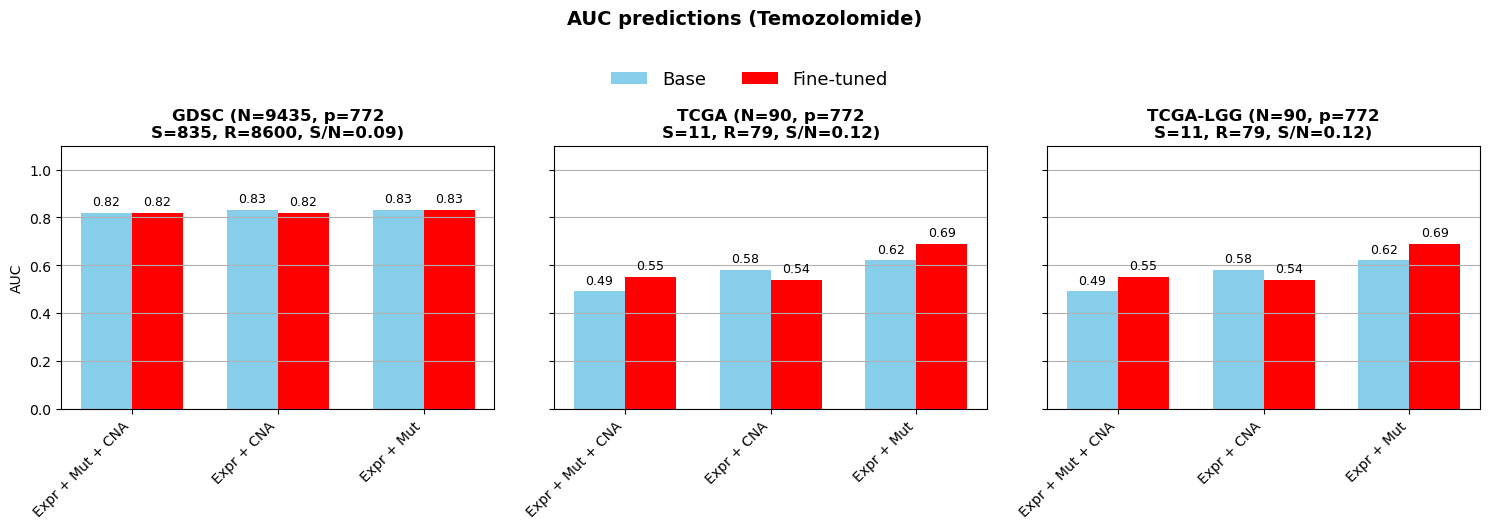

In [70]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Temozolomide)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Temozolomide).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [72]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                                 f"AUCPR (TCGA, N={str(len(Ytstemozolomide))})",
                                 f"AUCPR (TCGA-LGG, N={str(len(Ytstemozolomide_lgg))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (TCGA, N={str(len(Ytstemozolomide))})": f"TCGA (N={str(len(Ytstemozolomide))}, p=" + str(TCGAEtemozolomide.shape[1]) + "\nS=" + str(TCGARtemozolomide["response"].value_counts()[1]) + ", R=" + str(TCGARtemozolomide["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARtemozolomide["response"].value_counts()[1]/sum(TCGARtemozolomide["response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA-LGG, N={str(len(Ytstemozolomide_lgg))})": f"TCGA-LGG (N={str(len(Ytstemozolomide_lgg))}, p=" + str(TCGAEtemozolomide.shape[1]) + "\nS=" + str(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts()[1]) + ", R=" + str(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts()[1]/sum(TCGARtemozolomide.loc[TCGARtemozolomide["cohort"] == "LGG","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=9435, p=772\nS=835, R=8600, S/N=0.09)","TCGA (N=90, p=772\nS=11, R=79, S/N=0.12)","TCGA-LGG (N=90, p=772\nS=11, R=79, S/N=0.12)"
Data,,,
Expr + Mut + CNA,0.34,0.16,0.16
Expr + Mut + CNA (Fine-tuned),0.34,0.22,0.22
Expr + CNA,0.35,0.22,0.22
Expr + CNA (Fine-tuned),0.33,0.25,0.25
Expr + Mut,0.35,0.17,0.17
Expr + Mut (Fine-tuned),0.35,0.19,0.19


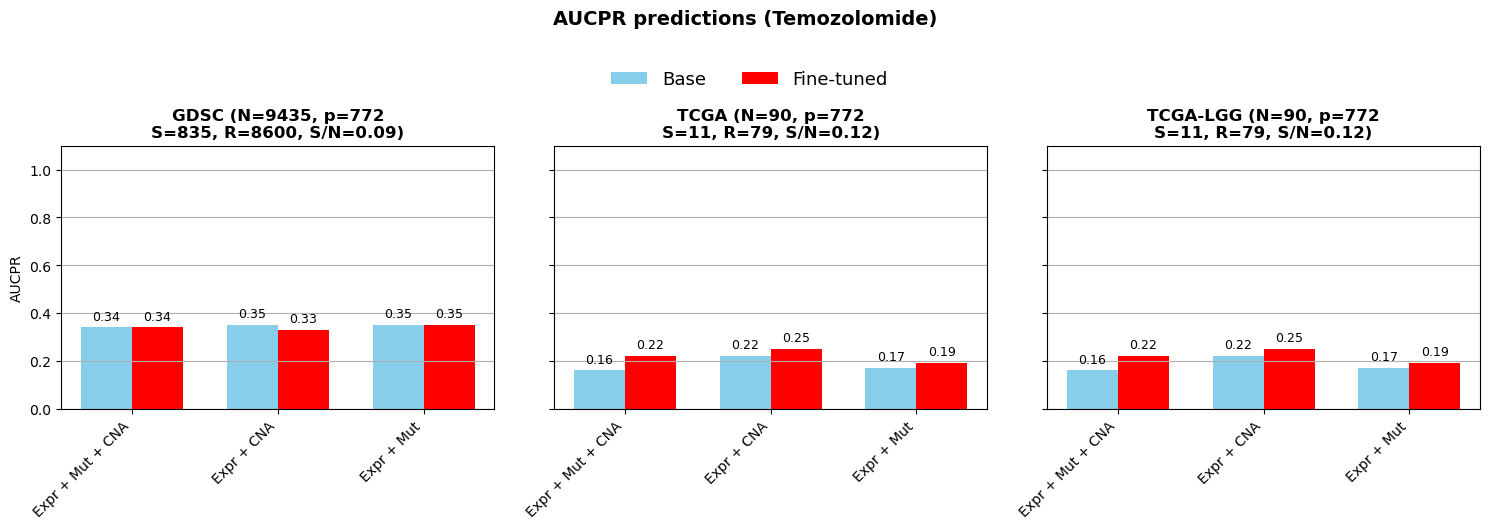

In [73]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Temozolomide)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Temozolomide).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [74]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/TCGA_DNA_REPi/Expression_CNA/Predictions


In [75]:
# save predictions

file = open('GDSC_TCGA_DEGs - TCGA_DNA_REPi_Temozolomide Predictions (Expression and CNA).txt', 'w')
file.write(f"GDSC Training (EC) AUC (TCGA_DNA_REPi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EC) AUCPR (TCGA_DNA_REPi): {round(AUCTaucpr,2)}\n\n")

file.write(f"TCGA Test (EC) AUC (Temozolomide): {round(AUCTtemozolomide,2)}\n")
file.write(f"TCGA Test (EC) AUCPR (Temozolomide): {round(AUCTtemozolomide_aucpr,2)}\n\n")

file.close()